In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")


def plot_1d_regression(
    x_star,
    gpm,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    gpm      --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    m_star, v_star = gpm.predict(x_star)

    f_lower = (
        m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    f_upper = (
        m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
   
    ax.fill_between(
        x_star.flatten(),
        f_lower.flatten(),
        f_upper.flatten(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.'
    )
    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = gpm.posterior_samples_f(
            x_star,
            num_samples
        )
        ax.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
        ax.plot([], [], 'r', lw=0.5, label="Posterior samples")

    ax.plot(gpm.X,
            gpm.Y,
            'kx',
            markersize=5,
            markeredgewidth=2,
            label='Observations'
    )

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best')
    
    return m_star, v_star

# Maximum Upper Interval

## Objectives

+ Develop intuition about the maximum upper interval acquisition function

## Exploration vs Exploitation

The question is this: "Where should we evaluate the function next if our goal is to maximize it?"
Two possibilities of choosing a point for the next evaluation are:
+ **Exploitation:** We can choose a point $\mathbf{x}$ that *exploits* our current state of knowledge by concentrating on the region where the model thinks the maximum is. In our working example, that would be the point right next to the left most observation.
+ **Exploration:** We can *explore* the regions of maximum predictive uncertainty because there is a high chance that they may hide the maximum of the function. In our working example, this is the region between the two observations on the right.

Generally speaking, it is a very bad idea to focus exclusive on either on exploration or exploitation.
On one hand, if we focus on exploration, then we will at the end recover the true response surface (and as a consequence we will get the correct maximum of the function) but we waste a lot of evaluations on regions that are very unlikely to contain the maximum.
If on the other hand we focus on exploitation, then we will very quickly converge to a local maximum, maybe a good one maybe a bad one, and a lot of the input space will remain unexplored, see the previous hands-on activity.

So, what should a good *information acquisition function* $a_n(\mathbf{x})$ for optimization do?
It should *strike a balance between exploration and exploitation* in a way that provably reveals, in the limit of large number of evaluations, the global maximum of the function.
Are there such information acquisition algorithms? Yes there are.
We are going to explore the first such acquisition function, the maximum upper interval, in this hands-on activity.

Let's reintroduce the same running example as the previous hands-on activity.

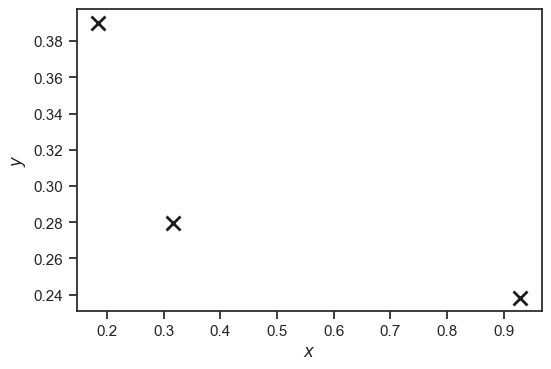

In [2]:
def f(x):
    """A function to optimize."""
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(12345)

n_init = 3

X = np.random.rand(n_init)
Y = f(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

## Maximum upper interval

Just like in the previous hands-on activity, assume that we have made some observations and that we have used them to do Gaussian process regression resulting in the point-predictive distribution:

$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$

where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.
Here is the code for this:

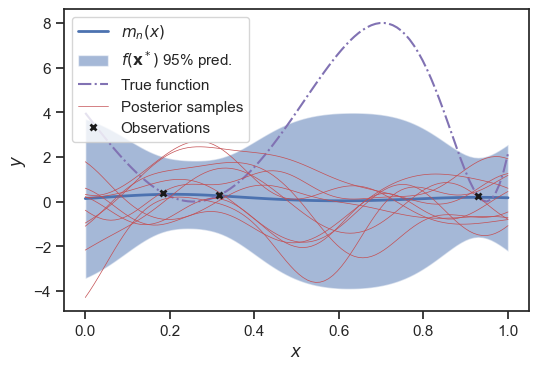

In [3]:
import GPy

k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
x_star = np.linspace(0, 1, 100)[:, None]
plot_1d_regression(x_star, gpr, f_true=f);

The maximum upper interval is defined to be:

$$
a_n(\mathbf{x}) = \mu_n(\mathbf{x}) + \psi \sigma_n(\mathbf{x}),
$$

for some $\psi \ge 0$.
Note that here we are using the predictive mean and variance.
The parametr $\psi$ controls how much emphasis you put on exploitation and exploration.
The choice $\psi = 0$ is full-on exploitation. You are just looking at the predictive mean.
The greater $\psi$ is, the more emphasis you put on the predictive standard deviation, i.e., the more you try to explore.
Okay, so the information acquisition function depends only on the posterior mean, variance, and that parameter $\psi$.
Let's implement it:

In [4]:
def mui(m, sigma, ymax, psi=1.96):
    """The maximum upper interval acquisition function."""
    return m + psi * sigma

Now let's write code that carries out Bayesian global optimization for using the maximum upper interval as the information acquisition function.

In [5]:
def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None
):
    """Plot the information acquisition function.
    
    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
              
    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    
    The evaluation of the informationa acquisition function
    is as follows:
    
        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )
    
    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )
    
    sigma = np.sqrt(v)
    af_values = alpha(m, sigma, Y.max(), **alpha_params)
    next_id = np.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]
    
    ax2 = ax.twinx()
    ax2.plot(x_star, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel(
        'Maximum Upper Interval',
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        np.linspace(0, af_max, 100),
        color=sns.color_palette()[1],
        linewidth=1
    )

Visualize this information acquisition function:

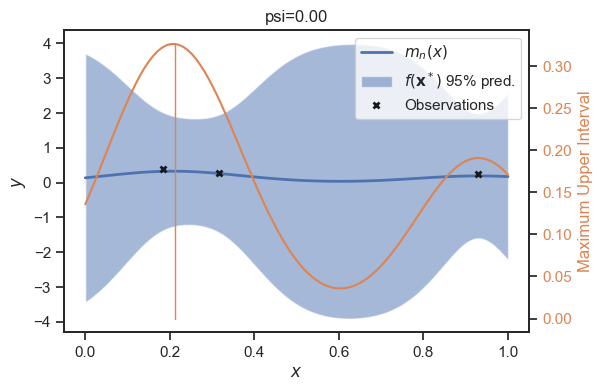

In [6]:
plot_iaf(
    x_star,
    gpr,
    mui,
    alpha_params=dict(psi=0.0)
)

### Questions
+ Experiment with different values of $\psi$.
+ When do you get exploration?
+ When do you get exploitation?

## Bayesian global optimization with the maximum upper interval

Let's now run the Bayesian global optimization algorithm using the maximum upper interval as the information acquisition function.
For convenience, I have written the following generic code for you:

In [7]:
def maximize(
    f,
    gpr,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.
    
    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowldege.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
    
    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.
                    
    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        m, sigma2 = gpr.predict(X_design)
        sigma = np.sqrt(sigma2)
        
        # Evaluate information acquisition function
        af_values = alpha(
            m,
            sigma,
            gpr.Y.max(),
            **alpha_params
        )
        
        # Find best point to include
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        af_all.append(af_values[i])

        # Make observation
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        # Update GPR
        gpr.set_XY(X, y)
        if optimize:
            gpr.optimize()
        
        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                gpr,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all

The code accepts the information acquisition function as an input.
Here is how you can use it:

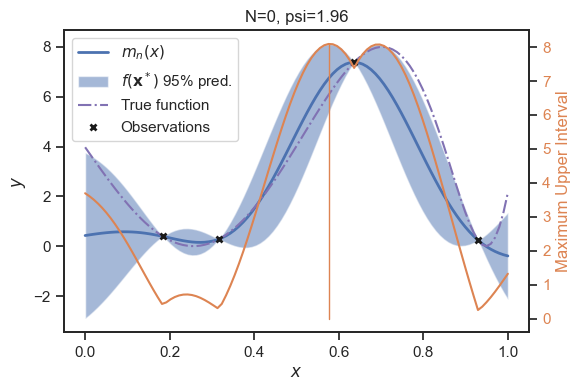

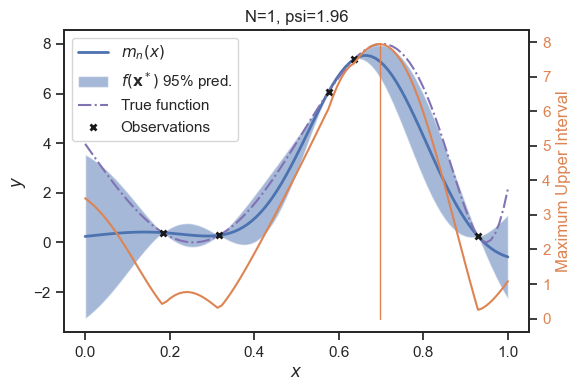

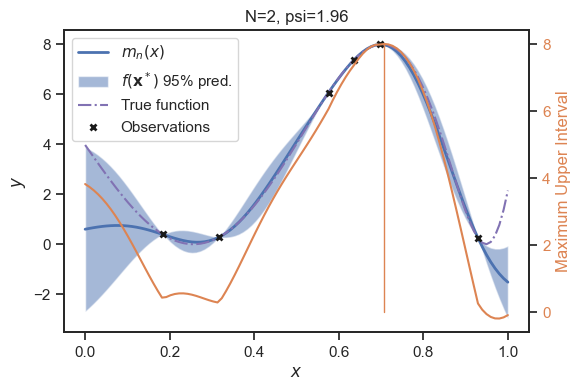

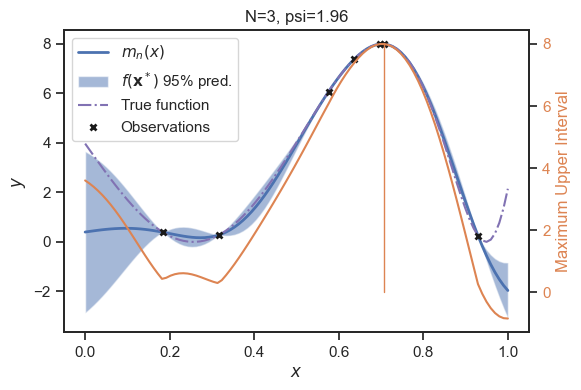

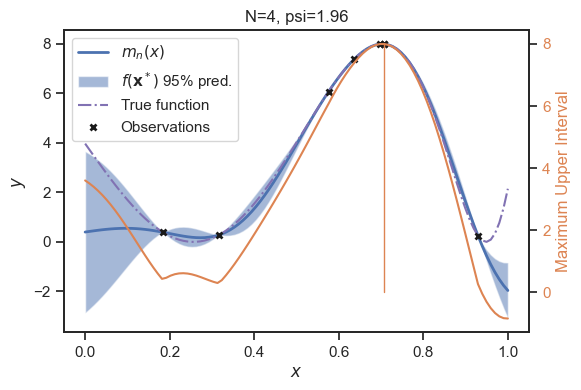

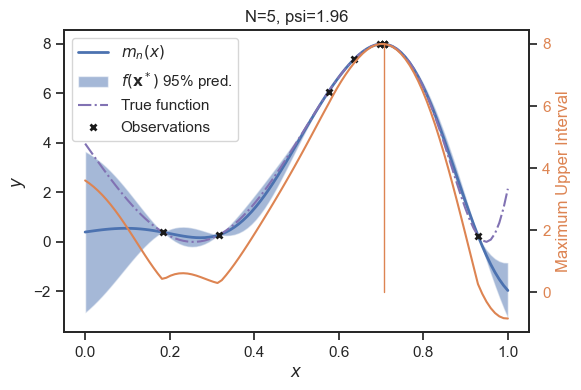

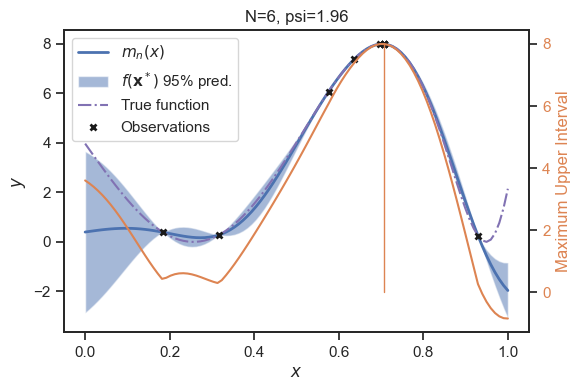

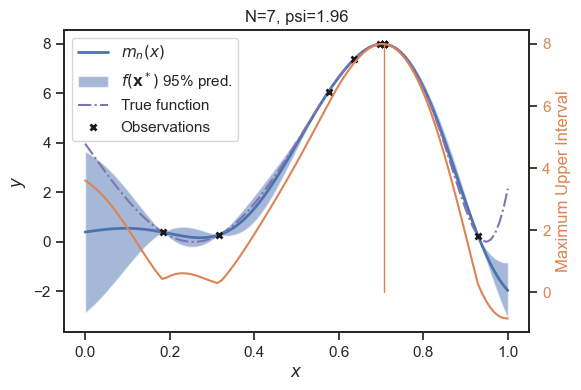

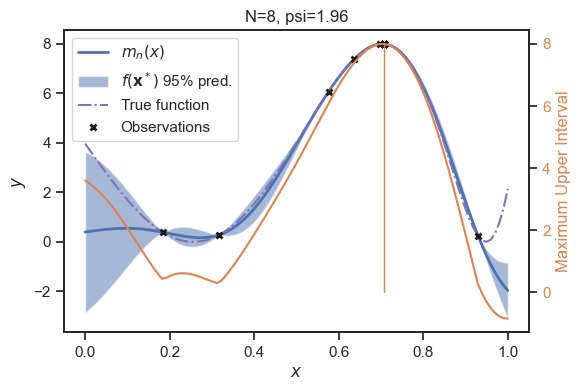

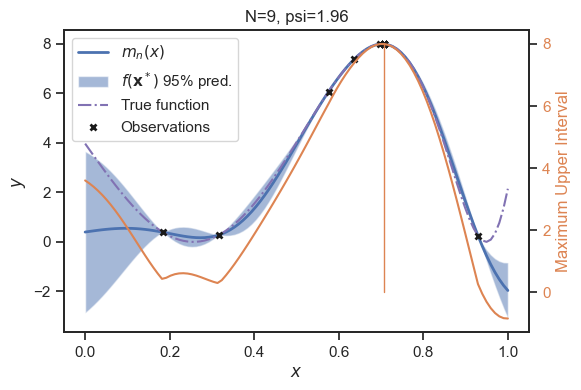

In [8]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(
    f,
    gpr,
    x_star,
    mui,
    alpha_params=dict(psi=1.96),
    max_it=10,
    plot=1
)

### Questions
+ Repeat the main algorithm using MUI for a $\psi$ that exploits. Does the method converge?
+ Repeat the main algorithm using MUI for a $\psi$ that explores. Does the method converge?